## 🎯 目标：门店商品销售预测

使用门店销售历史数据对未来每个门店的商品销售进行预测，从而进行库存预先安排

---
数据集来源于[kaggle](https://www.kaggle.com/competitions/demand-forecasting-kernels-only)


### 🔍 数据集说明


数据文件以csv格式存在，字段如下：
```text
date,store,item,sales
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
```

字段说明
- date：销售日期
- store：门店编号
- item：商品编号
- sales：销售数量
---


### 🎯 目标：预测未来的每个门店（store）每个商品（item）的销售数量（sales）

---



## 🧠 程序部分

程序分为以下部分：
1. 数据探索（EDA）
2. 简单基准模型（Naive baseline）
3. 特征工程
4. 强基准模型（autoML）
5. LightGBM模型训练
6. 对测试数据集进行预测
7. 评估和结果说明

---



### 步骤一：数据探索（EDA）

1. 数据结构和初步检查 (Foundation)

- df.shape (大小)
- df.info() (类型、非空计数)
- df.head() (快速查看)

2. 单变量分析 (Univariate Analysis)

- df.describe() (统计摘要，检查异常值)
- 直方图、箱线图 (查看分布和异常值)
   
3. 多变量分析 (Multivariate Analysis)

- 相关性矩阵 (查看特征与特征、特征与目标变量的关系)
- 散点图、分组图 (查看不同变量组合下的模式)



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

In [49]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])
sample_submission = pd.read_csv('data/sample_submission.csv')
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


#### 1. 数据探索

---



In [17]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

print("\n前面的数据行:")
display(train.head())

print("\n数据集结构描述:")
print(train.info())

print("\n数据集缺失值统计:")
print(train.isnull().sum())



Train shape: (913000, 4)
Test shape: (45000, 4)

前面的数据行:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10



数据集结构描述:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None

数据集缺失值统计:
date     0
store    0
item     0
sales    0
dtype: int64


#### 2. 单变量分析和探索

In [16]:
print("\n数值列统计摘要 (df.describe()) ##")
print(train.describe())


数值列统计摘要 (df.describe()) ##
                                date          store           item  \
count                         913000  913000.000000  913000.000000   
mean   2015-07-02 11:59:59.999999744       5.500000      25.500000   
min              2013-01-01 00:00:00       1.000000       1.000000   
25%              2014-04-02 00:00:00       3.000000      13.000000   
50%              2015-07-02 12:00:00       5.500000      25.500000   
75%              2016-10-01 00:00:00       8.000000      38.000000   
max              2017-12-31 00:00:00      10.000000      50.000000   
std                              NaN       2.872283      14.430878   

               sales  
count  913000.000000  
mean       52.250287  
min         0.000000  
25%        30.000000  
50%        47.000000  
75%        70.000000  
max       231.000000  
std        28.801144  


In [32]:
#  目标变量 sales 的分布（重要）
print("\n##  'sales' 分位数检查 ##")
print(train['sales'].quantile([0.01, 0.25, 0.5, 0.75, 0.99]))
# 进一步细化对异常值的检查。如果 99% 的值都在 150 以下，但 max 是 5000，则 5000 是一个强异常值。


##  'sales' 分位数检查 ##
0.01     10.0
0.25     30.0
0.50     47.0
0.75     70.0
0.99    135.0
Name: sales, dtype: float64


In [33]:
# matplotlib 上查看中文需要设置
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS'] # 尝试多个，以防第一个失败
plt.rcParams['font.serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False # 解决负号 '-' 显示为方块的问题

<Figure size 1000x600 with 0 Axes>

<Axes: xlabel='sales', ylabel='Count'>

Text(0.5, 1.0, 'Seaborn - 销售量 (Sales) 分布直方图 (含 KDE)')

Text(0.5, 0, '销售量 (Sales)')

Text(0, 0.5, '密度/频数')

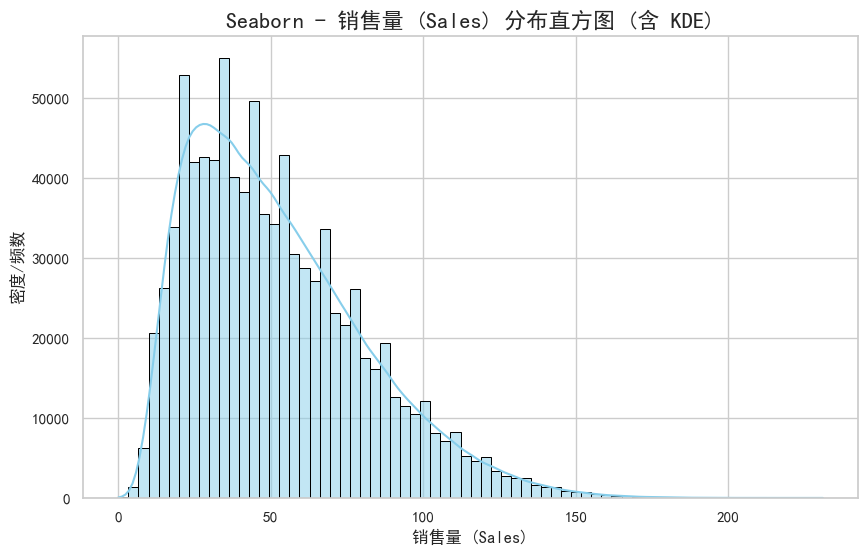

In [30]:
##  使用 Seaborn 绘制直方图和 KDE

plt.figure(figsize=(10, 6))

sns.histplot(
    train["sales"],
    bins=70,
    kde=True,            # 添加核密度估计线
    color='skyblue',
    edgecolor='black'
)

plt.title('Seaborn - 销售量 (Sales) 分布直方图 (含 KDE)', fontsize=16)
plt.xlabel('销售量 (Sales)', fontsize=12)
plt.ylabel('密度/频数', fontsize=12)
plt.show()

<Figure size 1000x600 with 0 Axes>

<Axes: ylabel='sales'>

Text(0.5, 1.0, 'Seaborn - 销售量 (Sales) 箱线图')

Text(0, 0.5, '销售量 (Sales)')

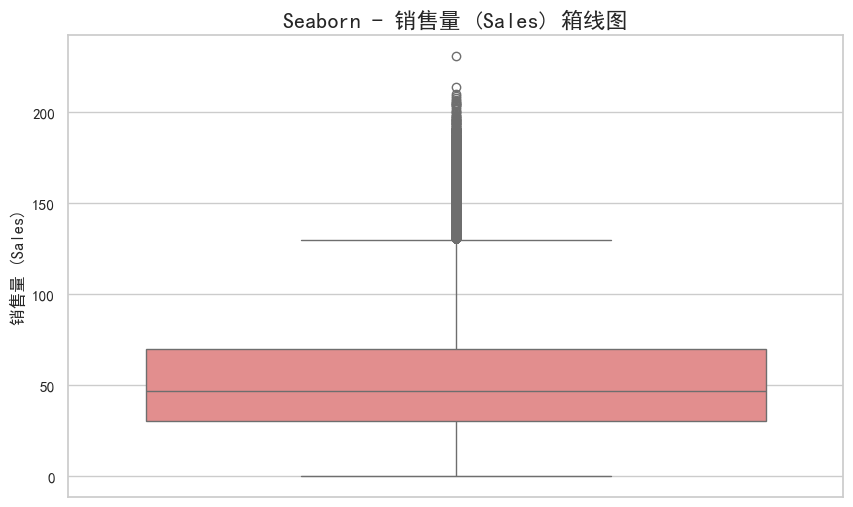

In [31]:
##  使用 Seaborn 绘制箱线图

plt.figure(figsize=(10, 6))

# 使用 sales_clean，即已经移除了 NaN 值的销售数据
sns.boxplot(
    y=train["sales"],       # 绘制垂直方向的箱线图
    color='lightcoral'   # 设置颜色
)

plt.title('Seaborn - 销售量 (Sales) 箱线图', fontsize=16)
plt.ylabel('销售量 (Sales)', fontsize=12)
plt.show()

**数据探索结论：** 数据高度右偏，使用LightGBM算法进行建模需要进行log(y+1) 对数转换

#### 3. 多变量分析(含时间序列分析)

对特征之间，特征和目标变量之间的关系进行探索


In [43]:
# 探索不同 store 对 sales 的影响
print("## 商店 (Store) 对销售量 (Sales) 的影响 ##")
store_sales_stats = train.groupby('store')['sales'].agg(['mean', 'median', 'std', 'count']).reset_index()
print(store_sales_stats.sort_values(by='mean', ascending=False))

print("\n## 商品 (Item) 对销售量 (Sales) 的影响 (只看Top 10) ##")
item_sales_stats = train.groupby('item')['sales'].agg(['mean', 'median', 'std']).reset_index()
print(item_sales_stats.sort_values(by='mean', ascending=True).head(10))

## 商店 (Store) 对销售量 (Sales) 的影响 ##
   store       mean  median        std  count
1      2  67.033165    62.0  33.595810  91300
7      8  64.142048    60.0  32.231751  91300
2      3  59.530602    55.0  29.974102  91300
9     10  58.709288    54.0  29.554994  91300
8      9  55.049025    51.0  27.832186  91300
3      4  54.902946    51.0  27.733097  91300
0      1  47.268379    44.0  24.006252  91300
4      5  39.770164    37.0  20.365757  91300
5      6  39.733516    37.0  20.310451  91300
6      7  36.363735    34.0  18.684825  91300

## 商品 (Item) 对销售量 (Sales) 的影响 (只看Top 10) ##
    item       mean  median        std
4      5  18.358708    18.0   7.265167
0      1  21.981599    21.0   8.468922
40    41  22.002136    21.0   8.402470
46    47  22.003341    21.0   8.420102
3      4  22.010241    21.0   8.403898
26    27  22.049726    21.0   8.461641
15    16  25.656079    25.0   9.603270
33    34  25.735761    25.0   9.617910
39    40  29.249398    28.0  10.822959
36    37  29.258379    28

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='store', ylabel='sales'>

Text(0.5, 1.0, '不同商店 (Store ID) 的销售量分布')

Text(0.5, 0, '商店 ID')

Text(0, 0.5, '销售量 (Sales)')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10')])

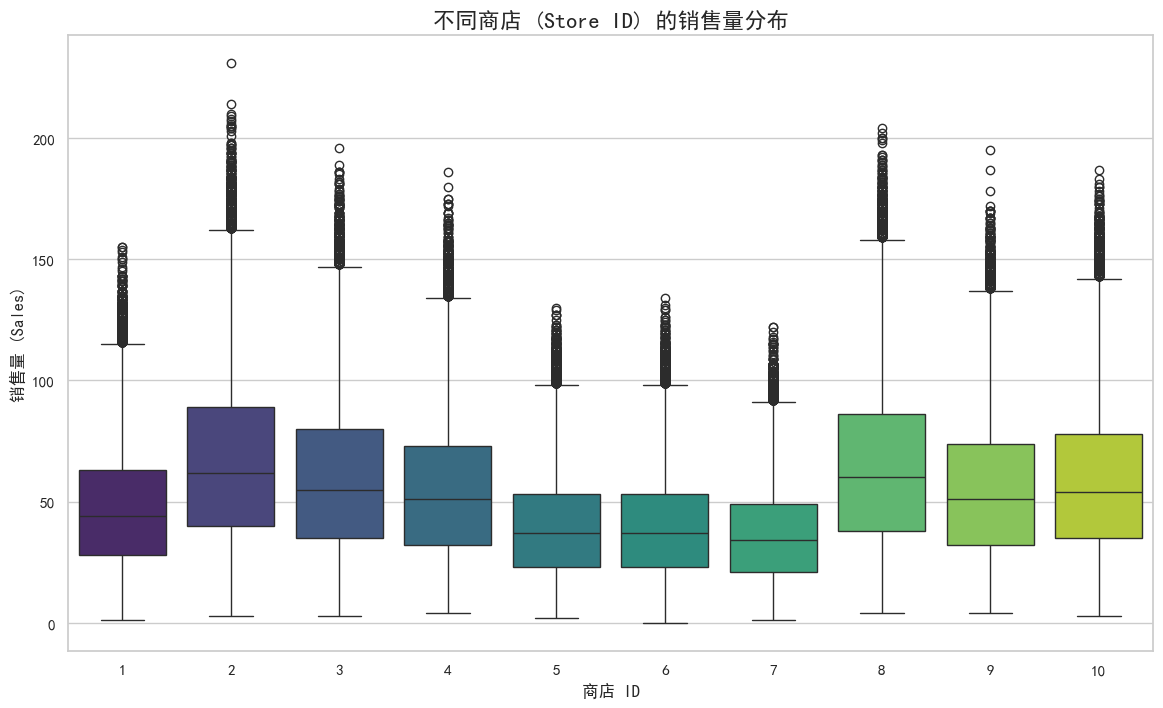

In [37]:
plt.figure(figsize=(14, 8))

# 绘制 store ID 对 sales 的箱线图
sns.boxplot(
    x=train["store"], 
    y=train["sales"], 
    data=train, # 排除缺失值
    palette='viridis'
)

plt.title('不同商店 (Store ID) 的销售量分布', fontsize=16)
plt.xlabel('商店 ID', fontsize=12)
plt.ylabel('销售量 (Sales)', fontsize=12)
plt.xticks(rotation=0)
plt.show()

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='item', ylabel='sales'>

Text(0.5, 1.0, '不同商品 (item) 的销售量分布')

Text(0.5, 0, '商品 ID')

Text(0, 0.5, '销售量 (Sales)')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30'),
  Text(30, 0, '31'),
  Text(31, 0, '32'),
  Text(32, 0, '33'),
  Text(33, 0, '34'),
  Text(34, 0, 

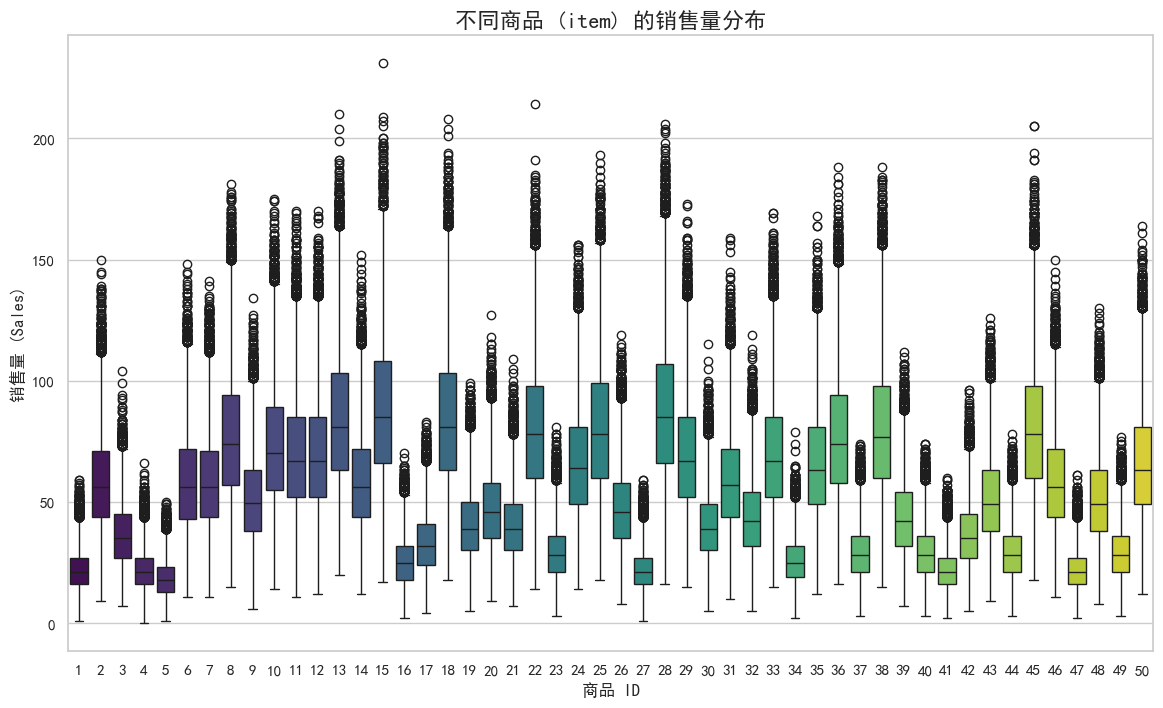

In [46]:
plt.figure(figsize=(14, 8))

# 绘制 item 对 sales 的箱线图
sns.boxplot(
    x=train["item"], 
    y=train["sales"], 
    data=train, # 排除缺失值
    palette='viridis'
)

plt.title('不同商品 (item) 的销售量分布', fontsize=16)
plt.xlabel('商品 ID', fontsize=12)
plt.ylabel('销售量 (Sales)', fontsize=12)
plt.xticks(rotation=0)
plt.show()

<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='date'>

Text(0.5, 1.0, '月度平均销售量趋势')

Text(0.5, 0, '日期')

Text(0, 0.5, '平均销售量')

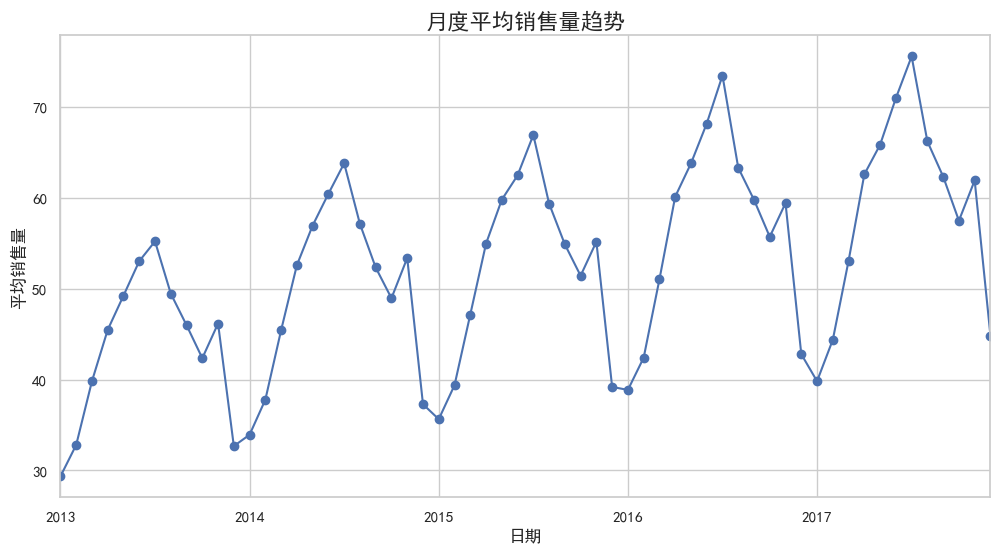

In [41]:
# 确保 date 是索引且数据按日期排序
df_ts = train.set_index('date').sort_index()

# 按月聚合销售量并计算均值
monthly_sales = df_ts['sales'].resample('M').mean()

plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o', linestyle='-', color='b')
plt.title('月度平均销售量趋势', fontsize=16)
plt.xlabel('日期', fontsize=12)
plt.ylabel('平均销售量', fontsize=12)
plt.grid(True)
plt.show()

<Figure size 1200x700 with 0 Axes>

<Axes: xlabel='date'>

<Axes: xlabel='date'>

<Axes: xlabel='date'>

<Axes: xlabel='date'>

Text(0.5, 1.0, '精选商品 (Item) 月度总销售量对比')

Text(0.5, 0, '日期')

Text(0, 0.5, '总销售量')

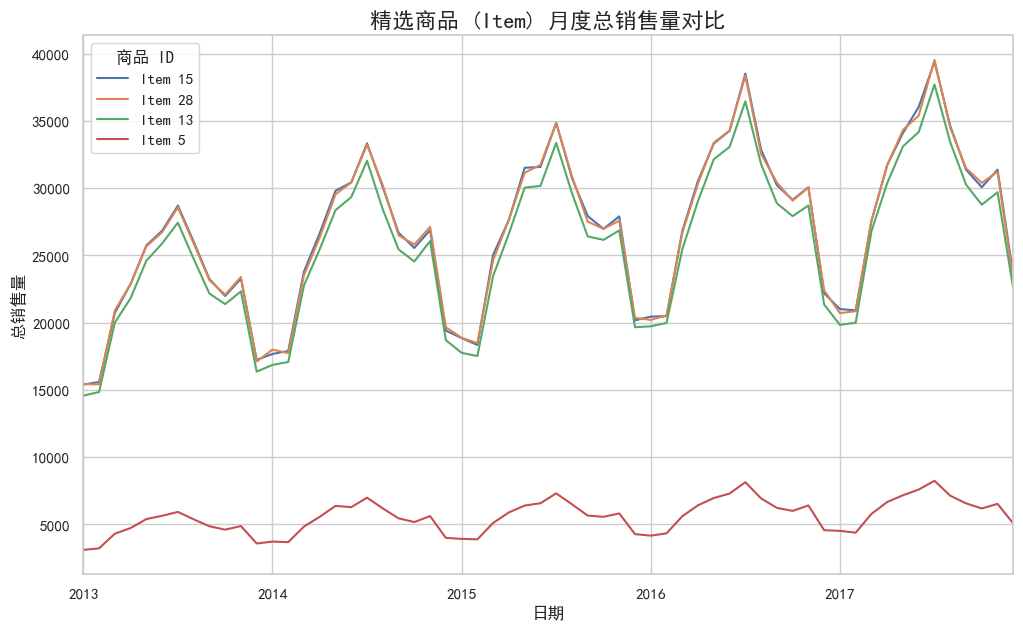

In [44]:
# 仅选择几个 Top Item ID 进行比较
top_items = [15, 28, 13] 

plt.figure(figsize=(12, 7))

for item_id in top_items:
    # 过滤出该 item 的数据，并按月聚合求和
    item_ts = df_ts[df_ts['item'] == item_id]['sales'].resample('M').sum().dropna()
    item_ts.plot(label=f'Item {item_id}')

plt.title('精选商品 (Item) 月度总销售量对比', fontsize=16)
plt.xlabel('日期', fontsize=12)
plt.ylabel('总销售量', fontsize=12)
plt.legend(title='商品 ID')
plt.grid(True)
plt.show()

### 步骤二：简单基准模型（Naive baseline）

使用所有时间的品均值作为预测值


In [48]:
# ==============================
# ⚡ 基准模型: 平均值作为预测值
# ==============================

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
import numpy as np

# Train/validation split (time-based: last 3 months = validation)
cutoff_date = "2017-10-01"
train_baseline = train[train["date"] < cutoff_date]
val_baseline   = train[train["date"] >= cutoff_date]

# Compute mean sales per (store, item) from training part
mean_sales = train_baseline.groupby(["store", "item"])["sales"].mean()

print(mean_sales.head(10))
# Predict validation: use group mean (fallback to global mean if missing)
val_preds = val_baseline.set_index(["store","item"]).index.map(
    lambda idx: mean_sales.get(idx, train_baseline["sales"].mean())
)

# True values
y_true = val_baseline["sales"].values
y_pred = np.array(val_preds)

# RMSLE (Kaggle metric)
score = np.sqrt(mean_squared_log_error(y_true, y_pred))
print(f"Baseline RMSLE: {score:.5f}")

store  item
1      1       19.957901
       2       52.978662
       3       33.165513
       4       19.931949
       5       16.585352
       6       52.889850
       7       52.662053
       8       69.289504
       9       46.476932
       10      66.153979
Name: sales, dtype: float64
Baseline RMSLE: 0.24273


### 步骤三：特征工程


In [54]:
# 合并训练和测试数据集，这样特征可以针对两个数据集一起建立
tr = train.copy(); te = test.copy()
tr["split"] = "train"; te["split"] = "test"
print(tr.head())
print(te.head())
df = pd.concat([tr, te], ignore_index=True).sort_values(["store","item","date"])
print()
print(df.head())
df.reset_index(drop=True, inplace=True)
print()
print(df.head)

print(df.index)

        date  store  item  sales  split
0 2013-01-01      1     1     13  train
1 2013-01-02      1     1     11  train
2 2013-01-03      1     1     14  train
3 2013-01-04      1     1     13  train
4 2013-01-05      1     1     10  train
   id       date  store  item split
0   0 2018-01-01      1     1  test
1   1 2018-01-02      1     1  test
2   2 2018-01-03      1     1  test
3   3 2018-01-04      1     1  test
4   4 2018-01-05      1     1  test

        date  store  item  sales  split  id
0 2013-01-01      1     1   13.0  train NaN
1 2013-01-02      1     1   11.0  train NaN
2 2013-01-03      1     1   14.0  train NaN
3 2013-01-04      1     1   13.0  train NaN
4 2013-01-05      1     1   10.0  train NaN

<bound method NDFrame.head of              date  store  item  sales  split       id
0      2013-01-01      1     1   13.0  train      NaN
1      2013-01-02      1     1   11.0  train      NaN
2      2013-01-03      1     1   14.0  train      NaN
3      2013-01-04      1     1  

#### 1. 构建时间特征

In [55]:
dt = df["date"]
dt

0        2013-01-01
1        2013-01-02
2        2013-01-03
3        2013-01-04
4        2013-01-05
            ...    
957995   2018-03-27
957996   2018-03-28
957997   2018-03-29
957998   2018-03-30
957999   2018-03-31
Name: date, Length: 958000, dtype: datetime64[ns]

In [58]:
df["dow"]       = dt.dt.dayofweek.astype("int8")
df["is_weekend"]= df["dow"].isin([5,6]).astype("int8")
df["month"]     = dt.dt.month.astype("int8")
df["year"]      = dt.dt.year.astype("int16")
df["day"]       = dt.dt.day.astype("int8")
df["woy"]       = dt.dt.isocalendar().week.astype("int16")
df["quarter"]   = dt.dt.quarter.astype("int8")
df["m_start"]   = dt.dt.is_month_start.astype("int8")
df["m_end"]     = dt.dt.is_month_end.astype("int8")
df.head(10)

,date,store,item,sales,split,id,dow,is_weekend,month,year,day,woy,quarter,m_start,m_end
0,2013-01-01,1,1,13.0,train,NaN,1,0,1,2013,1,1,1,1,0
1,2013-01-02,1,1,11.0,train,NaN,2,0,1,2013,2,1,1,0,0
2,2013-01-03,1,1,14.0,train,NaN,3,0,1,2013,3,1,1,0,0
3,2013-01-04,1,1,13.0,train,NaN,4,0,1,2013,4,1,1,0,0
4,2013-01-05,1,1,10.0,train,NaN,5,1,1,2013,5,1,1,0,0
5,2013-01-06,1,1,12.0,train,NaN,6,1,1,2013,6,1,1,0,0
6,2013-01-07,1,1,10.0,train,NaN,0,0,1,2013,7,2,1,0,0
7,2013-01-08,1,1,9.0,train,NaN,1,0,1,2013,8,2,1,0,0
8,2013-01-09,1,1,12.0,train,NaN,2,0,1,2013,9,2,1,0,0
9,2013-01-10,1,1,9.0,train,NaN,3,0,1,2013,10,2,1,0,0


#### 2. 构建滞后和滚动平均特征

In [62]:
g = df.groupby(["store","item"], group_keys=False)
for L in (1,7,14,28):
    df[f"lag_{L}"] = g["sales"].shift(L)

df["roll7"]  = g["sales"].shift(1).rolling(7,  min_periods=1).mean()
df["roll28"] = g["sales"].shift(1).rolling(28, min_periods=1).mean()

print(df.head(10))

print(df.info())

        date  store  item  sales  split  id  dow  is_weekend  month  year  \
0 2013-01-01      1     1   13.0  train NaN    1           0      1  2013   
1 2013-01-02      1     1   11.0  train NaN    2           0      1  2013   
2 2013-01-03      1     1   14.0  train NaN    3           0      1  2013   
3 2013-01-04      1     1   13.0  train NaN    4           0      1  2013   
4 2013-01-05      1     1   10.0  train NaN    5           1      1  2013   
5 2013-01-06      1     1   12.0  train NaN    6           1      1  2013   
6 2013-01-07      1     1   10.0  train NaN    0           0      1  2013   
7 2013-01-08      1     1    9.0  train NaN    1           0      1  2013   
8 2013-01-09      1     1   12.0  train NaN    2           0      1  2013   
9 2013-01-10      1     1    9.0  train NaN    3           0      1  2013   

   day  woy  quarter  m_start  m_end  lag_1  lag_7  lag_14  lag_28      roll7  \
0    1    1        1        1      0    NaN    NaN     NaN     NaN     

优化内存使用：

In [63]:
for c in ["store","item"]:
    df[c] = df[c].astype("int16").astype("category")
num_cols = ["lag_1","lag_7","lag_14","lag_28","roll7","roll28"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, downcast="float")

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958000 entries, 0 to 957999
Data columns (total 21 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        958000 non-null  datetime64[ns]
 1   store       958000 non-null  category      
 2   item        958000 non-null  category      
 3   sales       913000 non-null  float64       
 4   split       958000 non-null  object        
 5   id          45000 non-null   float64       
 6   dow         958000 non-null  int8          
 7   is_weekend  958000 non-null  int8          
 8   month       958000 non-null  int8          
 9   year        958000 non-null  int16         
 10  day         958000 non-null  int8          
 11  woy         958000 non-null  int16         
 12  quarter     958000 non-null  int8          
 13  m_start     958000 non-null  int8          
 14  m_end       958000 non-null  int8          
 15  lag_1       913000 non-null  float32       
 16  la

#### 3. 最终特征集合：

下面将使用以下特征集合来进行机器学习和预测
["store","item","dow","is_weekend","month","year","day","woy","quarter","m_start","m_end","lag_1","lag_7","lag_14","lag_28","roll7","roll28"]

In [65]:
# 最终特征集合
feat_cols = ["store","item","dow","is_weekend","month","year","day","woy","quarter","m_start","m_end",
             "lag_1","lag_7","lag_14","lag_28","roll7","roll28"]


             date store item  sales  split  id  dow  is_weekend  month  year  \
0      2013-01-01     1    1   13.0  train NaN    1           0      1  2013   
1      2013-01-02     1    1   11.0  train NaN    2           0      1  2013   
2      2013-01-03     1    1   14.0  train NaN    3           0      1  2013   
3      2013-01-04     1    1   13.0  train NaN    4           0      1  2013   
4      2013-01-05     1    1   10.0  train NaN    5           1      1  2013   
...           ...   ...  ...    ...    ...  ..  ...         ...    ...   ...   
957905 2017-12-27    10   50   63.0  train NaN    2           0     12  2017   
957906 2017-12-28    10   50   59.0  train NaN    3           0     12  2017   
957907 2017-12-29    10   50   74.0  train NaN    4           0     12  2017   
957908 2017-12-30    10   50   62.0  train NaN    5           1     12  2017   
957909 2017-12-31    10   50   82.0  train NaN    6           1     12  2017   

        day  woy  quarter  m_start  m_e

准备用于机器学习的训练和验证数据集

In [ ]:
# 重新拆开训练集和测试集
df_tr = df[df["split"]=="train"].copy()
df_te = df[df["split"]=="test"].copy()

print(df_tr)
print(df_te)

从训练数据集中拆分训练集和验证集，后三个月用于验证我们的模型

In [71]:
cutoff = pd.Timestamp("2017-10-01")  # last ~3 months as validation
tr_mask = df_tr["date"] < cutoff
va_mask = df_tr["date"] >= cutoff

print(tr_mask)
print(va_mask)

X_train = df_tr.loc[tr_mask, feat_cols]
print(X_train)

y_train = df_tr.loc[tr_mask, "sales"].astype("float32")
print(y_train)

X_val   = df_tr.loc[va_mask, feat_cols]
y_val   = df_tr.loc[va_mask, "sales"].astype("float32")

X_test  = df_te[feat_cols]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)

0          True
1          True
2          True
3          True
4          True
          ...  
957905    False
957906    False
957907    False
957908    False
957909    False
Name: date, Length: 913000, dtype: bool
0         False
1         False
2         False
3         False
4         False
          ...  
957905     True
957906     True
957907     True
957908     True
957909     True
Name: date, Length: 913000, dtype: bool
       store item  dow  is_weekend  month  year  day  woy  quarter  m_start  \
0          1    1    1           0      1  2013    1    1        1        1   
1          1    1    2           0      1  2013    2    1        1        0   
2          1    1    3           0      1  2013    3    1        1        0   
3          1    1    4           0      1  2013    4    1        1        0   
4          1    1    5           1      1  2013    5    1        1        0   
...      ...  ...  ...         ...    ...   ...  ...  ...      ...      ...   
957813    10   

### 步骤四：使用autoML（autogluon）进行预测

❗这个步骤非常耗时，可以最后再进行，我们发现**后面的LightGBM很难超越这个结果**，而我们仅仅限定了三种模型进行训练，如果放开模型选择，可能预测会更好。

In [105]:
# ==================== 1. 安装（只跑一次） ====================
# pip install autogluon

# ==================== 2. 导入 + 数据准备（和原来几乎一样） ====================

from autogluon.tabular import TabularPredictor


# 假设你原来是这样的数据结构（X_train/y_train 是 DataFrame/Series）
# X_train, X_val, y_train, y_val 已经是 pandas DataFrame/Series

# AutoGluon 要求训练数据是「带 label 的 DataFrame」
train_data = X_train.copy()
train_data['sales'] = y_train.values                   # ← 目标列必须叫 sales（或改下面 label=）

val_data = X_val.copy()
val_data['sales'] = y_val.values

# 类别特征一定要是 category 类型（AutoGluon 能自动识别，但保险起见）
cat_feats = ["store", "item", "dow", "month", "quarter"]
for col in cat_feats:
    if col in train_data.columns:
        train_data[col] = train_data[col].astype('category')
        val_data[col]   = val_data[col].astype('category')

# ==================== 3. 一键 AutoGluon 训练（替换你原来所有 LGBM 代码） ====================
predictor = TabularPredictor(
    label='sales',                     # 目标列名
    problem_type='regression',
    eval_metric='root_mean_squared_error',
    path='./autogluon_sales_model'     # 自动保存模型到这个文件夹
).fit(
    train_data=train_data,
    tuning_data=val_data,              # ← 直接把验证集给它，它自动做 early stopping
    # presets='best_quality',            # 最高性能模式（stacking + 加权集成）
    # time_limit=3600,                   # 1小时自动停（你电脑快的话 30分钟就够）
    use_bag_holdout=True,
    hyperparameters={'GBM':{}, 'XGB':{}, 'CAT':{}},   # 仅三剑客
    # time_limit=7200,                 # 想跑更强可以改 2小时
    verbosity=2
)

# ==================== 4. 直接预测 + 评估（和原来完全一样） ====================
val_pred = predictor.predict(val_data)          # 自动用最优集成模型
val_pred = np.clip(val_pred, 0, None)           # 防止负值

rmsle = np.sqrt(mean_squared_log_error(y_val, val_pred))
print(f"AutoGluon Validation RMSLE: {rmsle:.6f}")

# 看看内部到底用了哪些模型（经常能看到 LightGBM + XGBoost + CatBoost + 加权平均）
print(predictor.leaderboard(val_data, silent=False))

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.3
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       3.29 GB / 15.85 GB (20.8%)
Disk Space Avail:   97.45 GB / 237.83 GB (41.0%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='hi

[1000]	valid_set's rmse: 7.63687
[2000]	valid_set's rmse: 7.61014
[3000]	valid_set's rmse: 7.59995
[4000]	valid_set's rmse: 7.59929


	-7.598599910736084	 = Validation score   (-root_mean_squared_error)
	282.4s	 = Training   runtime
	6.23s	 = Validation runtime
Fitting model: CatBoost ...
	Fitting with cpus=10, gpus=0
	-7.526700019836426	 = Validation score   (-root_mean_squared_error)
	2615.81s	 = Training   runtime
	0.47s	 = Validation runtime
Fitting model: XGBoost ...
	Fitting with cpus=10, gpus=0
	-7.675000190734863	 = Validation score   (-root_mean_squared_error)
	36.09s	 = Training   runtime
	0.24s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'CatBoost': 0.923, 'LightGBM': 0.077}
	-7.526199817657471	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 2944.39s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 6857.8 rows/s (46000 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("d:\PyProjects\ml\autogluon_sales_model")


AutoGluon Validation RMSLE: 0.156921
                 model  score_test  score_val              eval_metric  pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   -7.526198  -7.526198  root_mean_squared_error        1.245369       6.707729  2898.236190                 0.003000                0.001000           0.021512            2       True          4
1             CatBoost   -7.526733  -7.526733  root_mean_squared_error        0.115374       0.474871  2615.811838                 0.115374                0.474871        2615.811838            1       True          2
2             LightGBM   -7.598605  -7.598605  root_mean_squared_error        1.126995       6.231859   282.402840                 1.126995                6.231859         282.402840            1       True          1
3              XGBoost   -7.674953  -7.674953  root_mean_squared_error        0.320321     

### 步骤五：使用LightGBM 进行预测

In [90]:
# =========================
# 🌿 Tiny LightGBM train
# =========================
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
import numpy as np

cat_feats = ["store","item","dow","month","quarter"]  # small, effective set

callbacks = [
    lgb.early_stopping(stopping_rounds=300, verbose=True),  # 耐心值 300
    lgb.log_evaluation(period=200)                          # 每 200 轮打印
]


model = LGBMRegressor(
    n_estimators=3000,
    learning_rate=0.03,
    num_leaves=100,
    subsample=0.8,            # 强烈推荐 0.6~0.9
    # colsample_bytree=0.8,     # 列采样，每棵树随机用 80% 特征
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=callbacks
    # early_stopping removed in some LightGBM builds; if available:
    # callbacks=[lightgbm.early_stopping(100), lightgbm.log_evaluation(100)]
)

# Evaluate (RMSLE)
val_pred = np.clip(model.predict(X_val), 0, None)
rmsle = np.sqrt(mean_squared_log_error(y_val, val_pred))
print(f"Validation RMSLE: {rmsle:.5f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 17
[LightGBM] [Info] Start training from score 52.121505
Training until validation scores don't improve for 300 rounds
[200]	valid_0's rmse: 7.75647	valid_0's l2: 60.1627
[400]	valid_0's rmse: 7.67783	valid_0's l2: 58.9491
[600]	valid_0's rmse: 7.64677	valid_0's l2: 58.4731
[800]	valid_0's rmse: 7.63128	valid_0's l2: 58.2365
[1000]	valid_0's rmse: 7.62263	valid_0's l2: 58.1045
[1200]	valid_0's rmse: 7.61718	valid_0's l2: 58.0214
[1400]	valid_0's rmse: 7.61284	valid_0's l2: 57.9554
[1600]	valid_0's rmse: 7.61071	valid_0's l2: 57.9229
[1800]	valid_0's rmse: 7.60893	valid_0's l2: 57.8958
[2000]	valid_0's rmse: 7.60802	valid_0's l2: 57.8819
[220

,boosting_type,'gbdt'
,num_leaves,100
,max_depth,-1
,learning_rate,0.03
,n_estimators,3000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Validation RMSLE: 0.15814


In [84]:
import numpy as np
import lightgbm as lgb  # ← 必须用 lgb 别名来调用 callbacks
from sklearn.metrics import mean_squared_log_error

cat_feats = ["store", "item", "dow", "month", "quarter"]

# ==================== 1. log1p 变换（不变） ====================
y_train_log = np.log1p(y_train)
y_val_log   = np.log1p(y_val)

# ==================== 2. 模型 & 训练（用 callbacks 修复 early_stopping） ====================
model = LGBMRegressor(
    n_estimators=5000,        # 给足迭代，early stopping 会停
    learning_rate=0.03,
    num_leaves=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# 定义 callbacks（这是 >=4.0.0 的标准写法）
callbacks = [
    lgb.early_stopping(stopping_rounds=300, verbose=True),  # 耐心值 300
    lgb.log_evaluation(period=200)                          # 每 200 轮打印
]

model.fit(
    X_train, y_train_log,
    eval_set=[(X_val, y_val_log)],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=callbacks  # ← 这里传入 callbacks 列表
)

print(f"Best iteration: {model.best_iteration_}")

# ==================== 3. 预测 & 逆变换（不变） ====================
val_pred_log = model.predict(X_val, num_iteration=model.best_iteration_)
val_pred = np.expm1(val_pred_log)
val_pred = np.clip(val_pred, 0, None)

# ==================== 4. 评估 RMSLE（不变） ====================
rmsle = np.sqrt(mean_squared_log_error(y_val, val_pred))
print(f"Validation RMSLE: {rmsle:.5f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 17
[LightGBM] [Info] Start training from score 3.817370
Training until validation scores don't improve for 300 rounds
[200]	valid_0's rmse: 0.160148	valid_0's l2: 0.0256472
[400]	valid_0's rmse: 0.159105	valid_0's l2: 0.0253144
[600]	valid_0's rmse: 0.158684	valid_0's l2: 0.0251807
[800]	valid_0's rmse: 0.158456	valid_0's l2: 0.0251084
[1000]	valid_0's rmse: 0.158296	valid_0's l2: 0.0250575
[1200]	valid_0's rmse: 0.158189	valid_0's l2: 0.0250238
[1400]	valid_0's rmse: 0.158141	valid_0's l2: 0.0250086
[1600]	valid_0's rmse: 0.158064	valid_0's l2: 0.0249841
[1800]	valid_0's rmse: 0.158014	valid_0's l2: 0.0249683
[2000]	valid_0's rmse: 0.157999

,boosting_type,'gbdt'
,num_leaves,100
,max_depth,-1
,learning_rate,0.03
,n_estimators,5000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Best iteration: 2599
Validation RMSLE: 0.15794


In [76]:
cat_feats = ["store","item","dow","month","quarter"] 

In [77]:
model = LGBMRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [78]:
X_train

,store,item,dow,is_weekend,month,year,day,woy,quarter,m_start,m_end,lag_1,lag_7,lag_14,lag_28,roll7,roll28
0,1,1,1,0,1,2013,1,1,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,0,1,2013,2,1,1,0,0,13.0,NaN,NaN,NaN,13.000000,13.000000
2,1,1,3,0,1,2013,3,1,1,0,0,11.0,NaN,NaN,NaN,12.000000,12.000000
3,1,1,4,0,1,2013,4,1,1,0,0,14.0,NaN,NaN,NaN,12.666667,12.666667
4,1,1,5,1,1,2013,5,1,1,0,0,13.0,NaN,NaN,NaN,12.750000,12.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912903,10,50,1,0,9,2017,26,39,3,0,0,63.0,84.0,70.0,79.0,85.857140,85.678574
912904,10,50,2,0,9,2017,27,39,3,0,0,79.0,72.0,84.0,79.0,85.142860,85.678574
912905,10,50,3,0,9,2017,28,39,3,0,0,80.0,89.0,90.0,89.0,86.285713,85.714287
912906,10,50,4,0,9,2017,29,39,3,0,0,82.0,97.0,94.0,96.0,85.285713,85.464287


In [79]:
y_train

0          13.0
1          11.0
2          14.0
3          13.0
4          10.0
          ...  
912903     79.0
912904     80.0
912905     82.0
912906     90.0
912907    103.0
Name: sales, Length: 867000, dtype: float32

In [80]:
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="rmse",
    categorical_feature=cat_feats,
    callbacks=[]
    # early_stopping removed in some LightGBM builds; if available:
    # callbacks=[lightgbm.early_stopping(100), lightgbm.log_evaluation(100)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1457
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 17
[LightGBM] [Info] Start training from score 52.121505


,boosting_type,'gbdt'
,num_leaves,63
,max_depth,-1
,learning_rate,0.05
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [81]:
val_pred = np.clip(model.predict(X_val), 0, None)
rmsle = np.sqrt(mean_squared_log_error(y_val, val_pred))
print(f"Validation RMSLE: {rmsle:.5f}")

Validation RMSLE: 0.15807


### 步骤六：对测试数据集进行预测

In [97]:
# =========================
# 📝 Predict & Submission
# =========================
test_pred = np.clip(model.predict(X_test), 0, None)

print(test_pred)

sub = sample_submission.copy()


sub["sales"] = test_pred
sub.head()

[12.42352698 12.49573218 12.67886895 ... 39.01499813 40.65313265
 41.41334806]


,id,sales
0,0,12.423527
1,1,12.495732
2,2,12.678869
3,3,13.888807
4,4,14.721740


### 步骤七：评估和结果说明

🎯 最佳预测结果：
- AutoGluon Validation RMSLE: 0.156921
- 手工LightGBM的 RMSLE: 0.15807

In [113]:
print(y_pred)
print(val_pred.info())
val_pred_array=np.array(val_pred)
val_pred_array
y_pred

[19.95790081 19.95790081 19.95790081 ... 73.88927336 73.88927336
 73.88927336]
<class 'pandas.core.series.Series'>
Index: 46000 entries, 1734 to 957909
Series name: sales
Non-Null Count  Dtype  
--------------  -----  
46000 non-null  float32
dtypes: float32(1)
memory usage: 539.1 KB
None


array([26.080435, 17.567854, 20.758293, ..., 66.3457  , 69.30073 ,
       73.3534  ], shape=(46000,), dtype=float32)

array([19.95790081, 19.95790081, 19.95790081, ..., 73.88927336,
       73.88927336, 73.88927336], shape=(46000,))

<Figure size 1200x500 with 0 Axes>

Text(0.5, 1.0, '比较: 200个样本的预测和真实值对比')

Text(0.5, 0, '样本')

Text(0, 0.5, '销售数量')

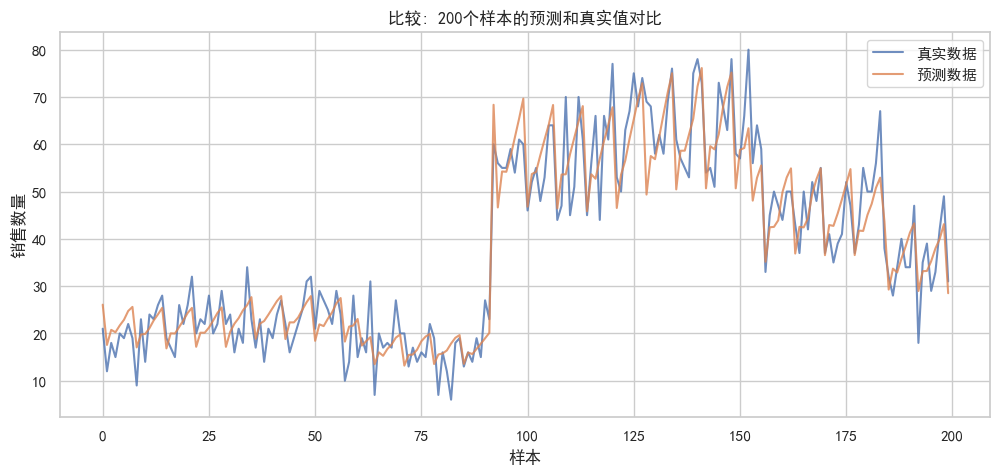

In [117]:
# =========================
# 📊 Plot: True vs Pred (Validation)
# =========================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_val.values[:200], label="真实数据", alpha=0.8)
plt.plot(val_pred_array[:200], label="预测数据", alpha=0.8)
plt.title("比较: 200个样本的预测和真实值对比")
plt.xlabel("样本")
plt.ylabel("销售数量")
plt.legend()
plt.show()